In [2]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import glob 
import os
import sqlite3
import shutil

### Step #1 : Data Preparation

In [3]:
# Define constants

# Path to the association.db file created during the AP Verify run
db_path = "/home/h/harshit/u/ap_verify_ci_cosmos_pdr2/butler_repo/association.db"
# Name of the table that contains data on dipoles
table_nm = "DiaSource"
# Column name to filter on
column_nm = "isDipole"
# Path to the directory where output images of analysis_ap.plotImageSubtractionCutouts are stored
triplets_root = "/home/h/harshit/public_html/images/"
# Path to the destination directory to save sample dipole cutouts
dest_dipoles_dir = "./dipole_cutouts"

In [4]:
# A method to read the APDB file and return dipoles
def read_apdb(db_path: str, get_only_dipoles: bool):
    conn = sqlite3.connect(db_path)
    
    # Check if only dipoles are required
    if get_only_dipoles:
        # Read a specific column of a table into a pandas DataFrame
        df = pd.read_sql(f"SELECT * FROM {table_nm} where {column_nm} = 1", conn)
    else:
        df = pd.read_sql(f"SELECT * FROM {table_nm}", conn)
    
    # Close the connection
    conn.close()
    
    return df

In [5]:
# Read the APDB file and return the dipoles
df = read_apdb(db_path = db_path, get_only_dipoles = True)

In [6]:
# A method to validate the supplied image path
def validate_img_path(path:str):
    if os.path.exists(path):
        return path
    return False

In [8]:
# Generate the image path using <diaSourceId> + ".png"
df['image_path'] = df.apply(lambda x: validate_img_path(triplets_root + str(x['diaSourceId']) + ".png"), axis=1)

In [9]:
# Write the output
df.to_csv("dc2_dipoles.csv", index=False)

In [10]:
# A method to validate and copy dipole cutout files from source to destination
def copy_dipole_cutouts(src_path, dest_path):
    if src_path is not False:
        shutil.copy(src_path, dest_path) 

In [11]:
# Copy all the dipoles from the source to the provided destination directory
df.apply(lambda x: copy_dipole_cutouts(x['image_path'], dest_dipoles_dir), axis=1)

0      None
1      None
2      None
3      None
4      None
       ... 
240    None
241    None
242    None
243    None
244    None
Length: 245, dtype: object

In [12]:
# Sort the SNR value in the descending order and pick the top 10 records with the highest SNR
df_top_10_snr = df.sort_values("snr",ascending=False).head(10)

In [13]:
# Write the 10 records with the highest SNR values to a CSV file
df_top_10_snr.to_csv("dc2_dipoles_demo.csv", index=False)

In [14]:
# Copy the corresponding dipole cutouts to a destination directory
dest_dipoles_dir = "./dc2_dipoles_demo"
df_top_10_snr.apply(lambda x: copy_dipole_cutouts(x['image_path'], dest_dipoles_dir), axis=1)

244    None
207    None
226    None
44     None
195    None
41     None
127    None
167    None
117    None
237    None
dtype: object

## Step #2 : Data Analysis

In [15]:
# Read the dipole CSV file for analysis
df_raw = pd.read_csv("dc2_dipoles.csv")

In [16]:
# Check the top 5 records
df_raw.head()

,diaSourceId,ccdVisitId,diaObjectId,ssObjectId,parentDiaSourceId,ssObjectReassocTime,midpointMjdTai,ra,raErr,dec,...,extendedness,reliability,flags,band,isDipole,time_processed,time_withdrawn,bboxSize,pixelId,image_path
0,25397870345584881,11826805,25397870345584881,0,0,NaN,57454.289074,149.670912,NaN,2.330680,...,NaN,NaN,14286848,g,1,2023-07-10 23:01:27.962635,NaN,33,15560557223122,/home/h/harshit/public_html/images/25397870345...
1,25397870345584884,11826805,25397870345584884,0,0,NaN,57454.289074,149.672185,NaN,2.316369,...,NaN,NaN,0,g,1,2023-07-10 23:01:27.962635,NaN,26,15560556747159,/home/h/harshit/public_html/images/25397870345...
2,25397870345584885,11826805,25397870345584885,0,0,NaN,57454.289074,149.673723,NaN,2.326487,...,NaN,NaN,40,g,1,2023-07-10 23:01:27.962635,NaN,23,15560557259958,/home/h/harshit/public_html/images/25397870345...
3,25397870345584889,11826805,25397870345584889,0,0,NaN,57454.289074,149.678981,NaN,2.347431,...,NaN,NaN,8388608,g,1,2023-07-10 23:01:27.962635,NaN,26,15560557034281,/home/h/harshit/public_html/images/25397870345...
4,25397870345584891,11826805,25397870345584891,0,0,NaN,57454.289074,149.680953,NaN,2.355771,...,NaN,NaN,0,g,1,2023-07-10 23:01:27.962635,NaN,25,15560557067492,/home/h/harshit/public_html/images/25397870345...


In [17]:
# Keep only required columns
dipole_data = df_raw[["diaSourceId", "snr", "isDipole"]]

### 2.1 Number of Dipoles v/s Various SNR Bin Sizes

/tmp/ipykernel_699/3471400125.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


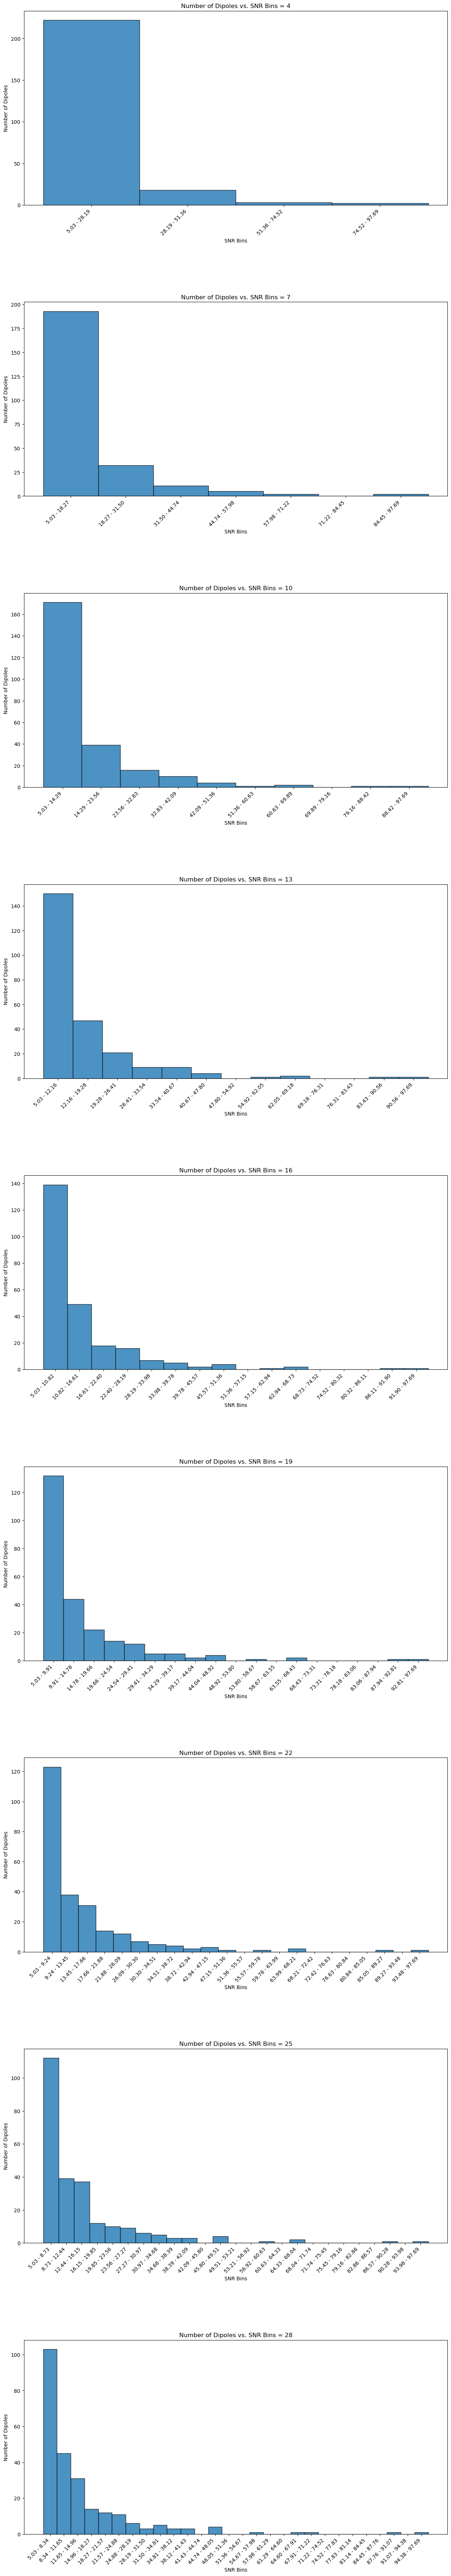

In [18]:
bin_ranges = list(range(5, 31, 3))

# Create a large figure
fig = plt.figure(figsize=(15, len(bin_ranges) * 10))

# Create a gridspec for the plots
gs = gridspec.GridSpec(len(bin_ranges), 1, hspace=0.5)

for idx, bin_c in enumerate(bin_ranges):
    bins = np.linspace(dipole_data['snr'].min(), dipole_data['snr'].max(), bin_c)
    labels = [f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(bins)-1)]
    
    ax = fig.add_subplot(gs[idx])
    ax.hist(dipole_data['snr'], bins=bins, edgecolor='black', alpha=0.8, align='left')
    
    ax.set_xticks(bins[:-1])
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('SNR Bins')
    ax.set_ylabel('Number of Dipoles')
    ax.set_title(f'Number of Dipoles vs. SNR Bins = {bin_c-1}')

plt.tight_layout()
plt.savefig('combined_histograms.png', dpi=300)  # Save the combined figure as an image
plt.show()


### 2.2 Percentage of diPoles vs. SNR bins

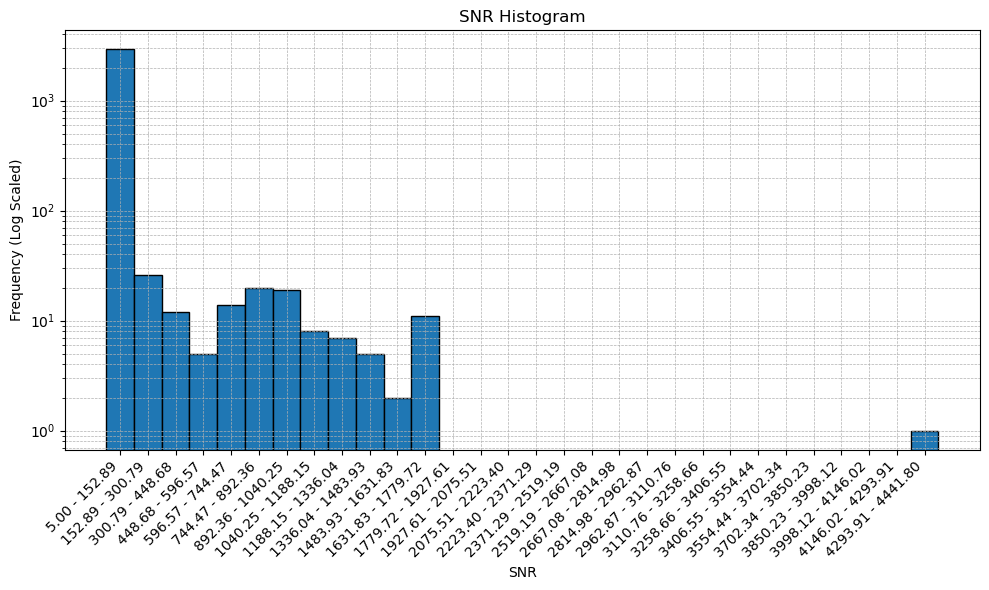

In [21]:
plt.figure(figsize=(10, 6))
hist, bins, _ = plt.hist(df['snr'], bins=30, edgecolor='k', align="left")
plt.xlabel('SNR')
plt.xticks(ticks=bins[:-1], labels=[f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(bins)-1)], rotation=45, ha="right")
plt.ylabel('Frequency (Log Scaled)')
plt.title('SNR Histogram')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('snr_histogram.png', dpi=300)
plt.show()

/tmp/ipykernel_699/3585974765.py:16: RuntimeWarning: invalid value encountered in divide
  percentage_dipoles = np.where(total == 0, 0, (dipoles_hist / total) * 100)
/tmp/ipykernel_699/3585974765.py:17: RuntimeWarning: invalid value encountered in divide
  percentage_non_dipoles = np.where(total == 0, 0, (non_dipoles_hist / total) * 100)


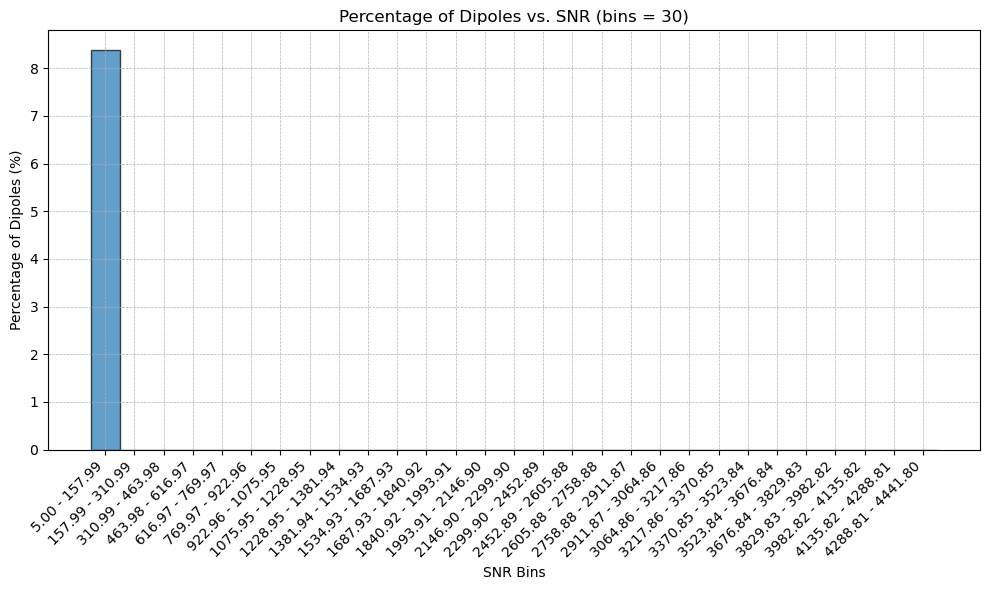

In [23]:
# For this analysis, we need all the records- dipoles and non-dipoles
df = read_apdb(db_path = db_path, get_only_dipoles = False)

# Calculate the max SNR value for a dipoles
max_snr = df['snr'].max()

# Define bins manually for better control
bins = np.linspace(df['snr'].min(), max_snr, 30)

# Get histograms for dipoles and non-dipoles
dipoles_hist, _ = np.histogram(df[df['isDipole'] == 1]['snr'], bins=bins)
non_dipoles_hist, _ = np.histogram(df[df['isDipole'] == 0]['snr'], bins=bins)

# Calculate the percentage for each bin
total = dipoles_hist + non_dipoles_hist
percentage_dipoles = np.where(total == 0, 0, (dipoles_hist / total) * 100)
percentage_non_dipoles = np.where(total == 0, 0, (non_dipoles_hist / total) * 100)
    
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], percentage_dipoles, width=np.diff(bins)[0], align='center', edgecolor='black', alpha=0.7)
plt.xticks(ticks=bins[:-1], labels=[f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(bins)-1)], rotation=45, ha='right')
plt.xlabel('SNR Bins')
plt.ylabel('Percentage of Dipoles (%)')
plt.title('Percentage of Dipoles vs. SNR (bins = 30)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # This ensures that x-axis labels fit properly
plt.savefig('percent_dipoles_vs_snr.png', dpi=300)
plt.show()

About 85% of all the observations having SNR values between 5.00 and 157.99 are dipoles.

/tmp/ipykernel_699/2761498490.py:14: RuntimeWarning: invalid value encountered in divide
  percentage_dipoles = np.where(total == 0, 0, (dipoles_hist / total) * 100)
/tmp/ipykernel_699/2761498490.py:15: RuntimeWarning: invalid value encountered in divide
  percentage_non_dipoles = np.where(total == 0, 0, (non_dipoles_hist / total) * 100)


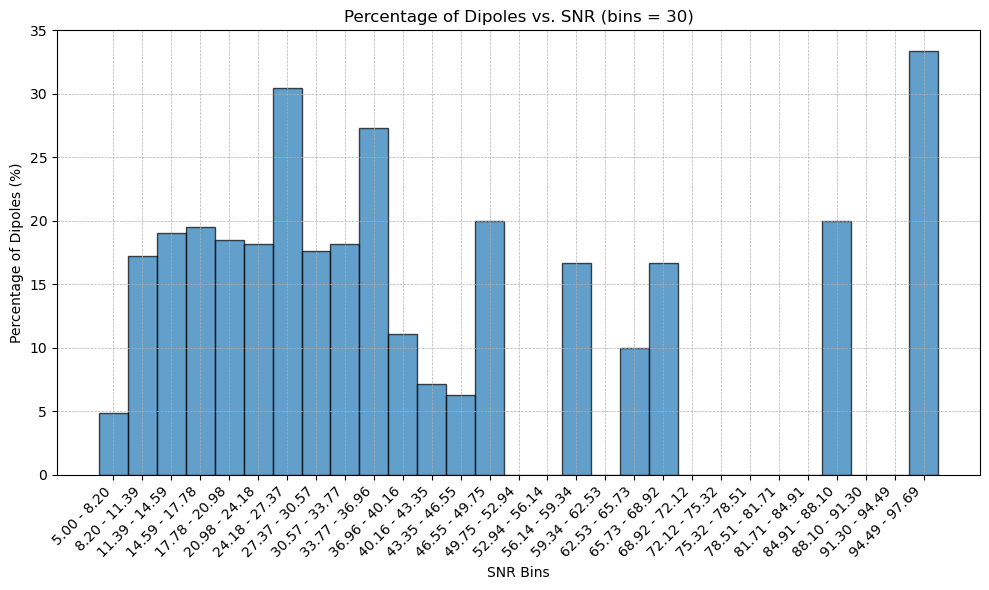

In [24]:
# Drill down on dipoles
# Calculate the max SNR value for a dipoles
max_snr_for_dipole = df[df['isDipole']==1]['snr'].max()

# Define bins manually for better control
bins = np.linspace(df['snr'].min(), max_snr_for_dipole, 30)

# Get histograms for dipoles and non-dipoles
dipoles_hist, _ = np.histogram(df[df['isDipole'] == 1]['snr'], bins=bins)
non_dipoles_hist, _ = np.histogram(df[df['isDipole'] == 0]['snr'], bins=bins)

# Calculate the percentage for each bin
total = dipoles_hist + non_dipoles_hist
percentage_dipoles = np.where(total == 0, 0, (dipoles_hist / total) * 100)
percentage_non_dipoles = np.where(total == 0, 0, (non_dipoles_hist / total) * 100)
    
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], percentage_dipoles, width=np.diff(bins)[0], align='center', edgecolor='black', alpha=0.7)
plt.xticks(ticks=bins[:-1], labels=[f"{bins[i]:.2f} - {bins[i+1]:.2f}" for i in range(len(bins)-1)], rotation=45, ha='right')
plt.xlabel('SNR Bins')
plt.ylabel('Percentage of Dipoles (%)')
plt.title('Percentage of Dipoles vs. SNR (bins = 30)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()  # This ensures that x-axis labels fit properly
plt.savefig('percent_dipoles_vs_snr_drilldown.png', dpi=300)
plt.show()

The above graph shows a more detailed/drill-down version of the occurance of dipoles for various SNR values